# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  5 22:46:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    38W / 250W |   8769MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 50
CLASSES = ["Normal", "Stroke"]

In [ ]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.Accuracy(),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Model Setup

In [ ]:
import os

DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

path, dirs, files = next(os.walk(DF_TRAIN + "/Stroke"))
file_count = len(files)
print('Stroke:', file_count)
path, dirs, files = next(os.walk(DF_TRAIN + "/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)

Stroke: 825
Non-Stroke: 1426


In [ ]:
import tensorflow as tf

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    DF_TRAIN,
    validation_split=0.20,
    subset="training",
    seed=1337,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)
valid_df = tf.keras.preprocessing.image_dataset_from_directory(
    DF_TRAIN,
    validation_split=0.2,
    subset="validation",
    seed=333,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    DF_TEST,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2251 files belonging to 2 classes.
Using 1801 files for training.
Found 2251 files belonging to 2 classes.
Using 450 files for validation.
Found 250 files belonging to 2 classes.


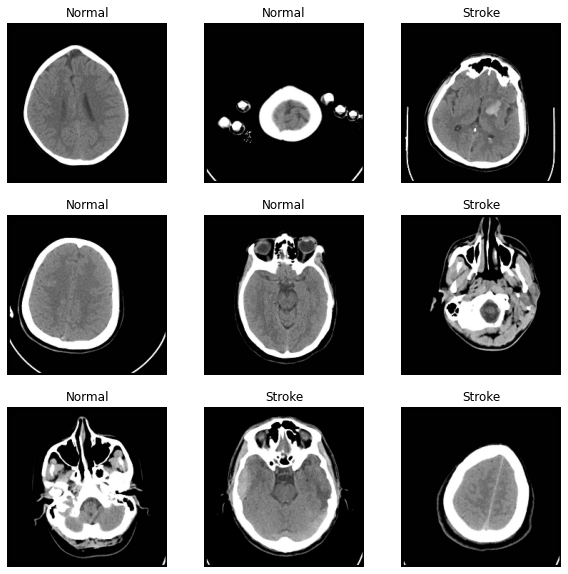

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1): 
  for i in range(9): 
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(images[i].numpy().astype("uint8")) 
    plt.title(CLASSES[int(labels[i])]) 
    plt.axis("off")

In [ ]:
import keras 
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=None, fill_mode='reflect',
        interpolation='bilinear', seed=None, fill_value=0.0),
                layers.experimental.preprocessing.RandomCrop(height= 224, width = 224, seed=None),
    ]
)

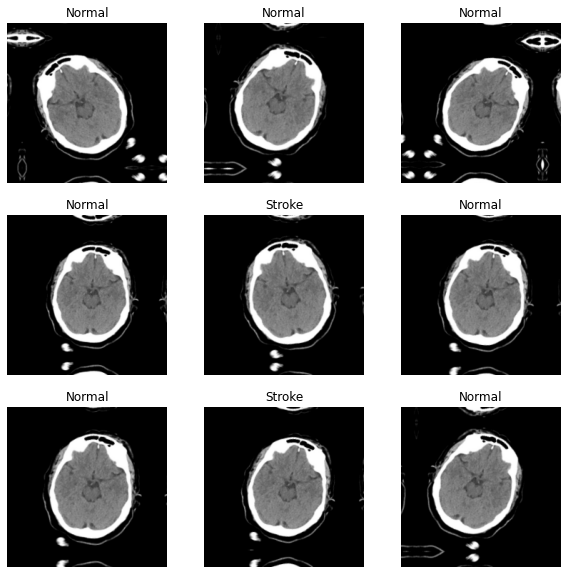

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])]) 
        plt.axis("off")

In [ ]:
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

**Auxiliar Functions**

In [ ]:
import matplotlib.pyplot as plt

def print_train_results(history):
  acc = history.history['BinaryAccuracy']
  val_acc = history.history['val_BinaryAccuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto') 
    callbacks.append(anne)
    return callbacks

# Manifold Learning

## Auxiliar Functions

In [ ]:
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = tf.keras.models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

def print2D(embedding, title):
  plt.figure(figsize=[25,10])
  plt.scatter(
      embedding[:, 0],
      embedding[:, 1])
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24)
  plt.show()

def print3D(embedding, title, classes):
  fig = plt.figure(figsize=[25,10])
  ax = plt.axes(projection ="3d")
  p = ax.scatter(
      embedding[:, 0],
      embedding[:, 1],
      embedding[:, 2],
      c = classes
  )
  plt.title(title, fontsize=24)
  fig.colorbar(p,boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

**LLE**

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

def lle(model, dataset, feature=True):
  embeddingLLE = LocallyLinearEmbedding(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresLLE = embeddingLLE.fit_transform(Y_pred)
  return featuresLLE

**Isomap**

In [ ]:
from sklearn.manifold import Isomap

def isomap(model, dataset, feature=True):
  embeddingIsomap = Isomap(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresIsomap = embeddingIsomap.fit_transform(Y_pred)
  return featuresIsomap

**t-SNE**

In [ ]:
from sklearn.manifold import TSNE

def tsne(model, dataset, feature=True):
  embeddingTSNE = TSNE(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresTSNE = embeddingTSNE.fit_transform(Y_pred)
  return featuresTSNE

**uMAP**

In [ ]:
!pip install umap-learn[plot]

     |████████████████████████████████| 86 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 20.1 MB/s 
     |████████████████████████████████| 15.8 MB 17.8 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 132 kB 46.1 MB/s 
     |████████████████████████████████| 802 kB 45.1 MB/s 
     |████████████████████████████████| 793 kB 53.9 MB/s 
     |████████████████████████████████| 793 kB 40.0 MB/s 
     |████████████████████████████████| 791 kB 35.1 MB/s 
     |████████████████████████████████| 786 kB 61.4 MB/s 
     |████████████████████████████████| 779 kB 36.2 MB/s 
     |████████████████████████████████| 778 kB 57.3 MB/s 
     |████████████████████████████████| 776 kB 48.0 MB/s 
     |████████████████████████████████| 769 kB 48.9 MB/s 
     |████████████████████████████████| 766 kB 48.9 MB/s 
     |████████████████████████████████| 1.0 MB 41.0 MB/s 
     |████████████████████████████████| 722 kB 55.4 MB/s 
     |███████████

In [ ]:
import umap

def uMAP(model, dataset, feature=True):
  embeddingUMAP = umap.UMAP(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresUMAP = embeddingUMAP.fit_transform(Y_pred)
  return featuresUMAP

## Manifold Tests

In [ ]:
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.efficientnet import preprocess_input

eff_model = EfficientNetB2(weights='imagenet', include_top=False)

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

eff_feature = eff_model.predict(img_data)

print(eff_feature.shape)

(1, 10, 10, 1408)


In [ ]:
Y_pred = eff_model.predict(valid_set)

eff_feature_list = []

for y_pred in Y_pred:
  eff_feature_np = np.array(y_pred)
  eff_feature_list.append(eff_feature_np.flatten())

eff_feature_list_np = np.array(eff_feature_list)

In [ ]:
from sklearn.manifold import Isomap
embeddingIsomap = Isomap(n_components=3)

In [ ]:
embeddingIsomapFeat = embeddingIsomap.fit_transform(eff_feature_list_np)

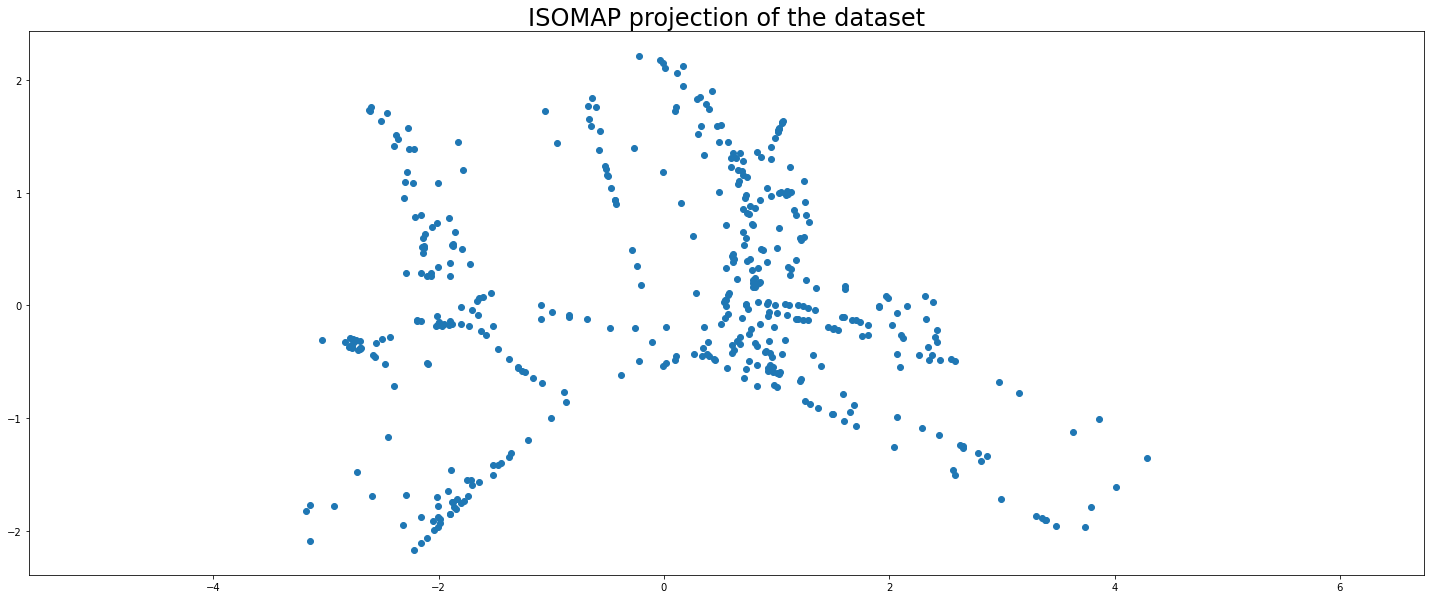

In [ ]:
print2D(embeddingIsomapFeat, "ISOMAP projection of the dataset")

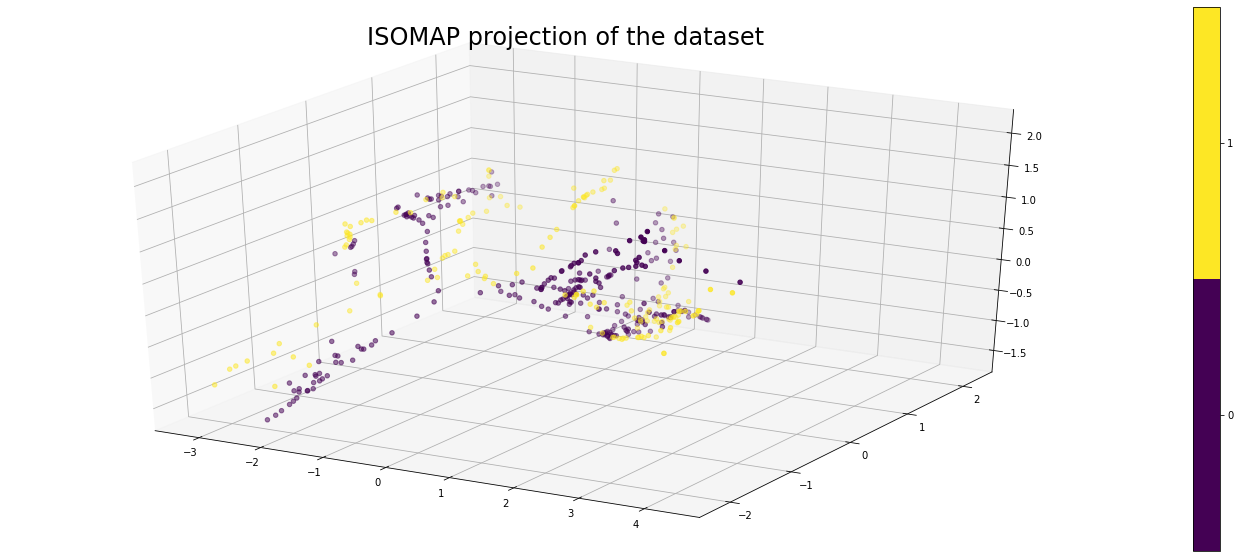

In [ ]:
print3D(embeddingIsomapFeat, "ISOMAP projection of the dataset", valid_set)

# VGG16

## Build Model

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
model_vgg16 = tf.keras.models.Model(name = "vgg16", inputs = base_model.input, outputs = predictions)
#model.load_weights(dire)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_vgg16.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

In [ ]:
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vgg16')
history = model_vgg16.fit(train_df,
                          epochs = EPOCHS,
                          validation_data = valid_df,
                          callbacks=[callbacks])

end = datetime.now()
print(end-start)

2021-12-05 21:38:03.046749
Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 1.0843 - tp: 12.0000 - fp: 22.0000 - tn: 1224.0000 - fn: 703.0000 - BinaryAccuracy: 0.6303 - precision: 0.3529 - recall: 0.0168 - auc: 0.5054
Epoch 00001: val_loss improved from inf to 0.68797, saving model to model.vgg16.h5
113/113 [==============================] - 18s 138ms/step - loss: 1.0843 - tp: 12.0000 - fp: 22.0000 - tn: 1224.0000 - fn: 703.0000 - BinaryAccuracy: 0.6303 - precision: 0.3529 - recall: 0.0168 - auc: 0.5054 - val_loss: 0.6880 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 273.0000 - val_fn: 177.0000 - val_BinaryAccuracy: 0.6067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5706 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.6566 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1147.0000 - fn: 654.0000 - BinaryAccuracy: 0.6369 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5221
Epoch 00002: val_loss improved f

In [ ]:
!cp '/content/model.vgg16.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vgg16.h5'

In [ ]:
print(history.history)

{'loss': [1.0843029022216797, 0.6566044092178345, 0.6594546437263489, 0.6567723155021667, 0.6749103665351868, 0.6700044274330139, 0.6521814465522766, 0.6486568450927734, 0.6396272778511047, 0.624506413936615, 0.5962139964103699, 0.5662774443626404, 0.5424669981002808, 0.5284358859062195, 0.4688410758972168, 0.4302535951137543, 0.3481264114379883, 0.28134116530418396, 0.20697984099388123, 0.22773881256580353, 0.1662285178899765, 0.13347236812114716, 0.11519265174865723, 0.0797581896185875, 0.02569674141705036, 0.019728276878595352, 0.011046366766095161, 0.0042705596424639225, 0.0017060104291886091, 0.0008419005898758769, 0.0005627361824735999, 0.0004392908012960106, 0.00038277829298749566, 0.00034843580215238035, 0.00032405831734649837, 0.0003111228870693594, 0.0002994276292156428, 0.00029301742324605584, 0.0002874802448786795, 0.0002843444235622883, 0.00028061337070539594, 0.000279086030786857, 0.00027732428861781955, 0.0002764331584330648, 0.00027549231890589, 0.00027498588315211236, 

In [ ]:
acc = history.history['val_accuracy']
val_acc = history.history['val_BinaryAccuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TypeError: ignored

## Evaluate Model

In [ ]:
# get results
results = model_vgg16.evaluate(test_df, steps = len(test_df), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 65ms/step - loss: 0.2277 - tp: 116.0000 - fp: 2.0000 - tn: 123.0000 - fn: 9.0000 - BinaryAccuracy: 0.9560 - precision: 0.9831 - recall: 0.9280 - auc: 0.9768


In [ ]:
# show results
print('VGG16:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

DesnseNet121:
---------------
ACCURACY: 0.956
Binary Accuracy: 0.9559999704360962
Precision: 0.9830508232116699
Recall: 0.9279999732971191
AUC: 0.9768319129943848
F1 Score: 0.9547324847217321


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.93         7
      Stroke       1.00      0.89      0.94         9

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16

Confusion Matrix
[[7 0]
 [1 8]]


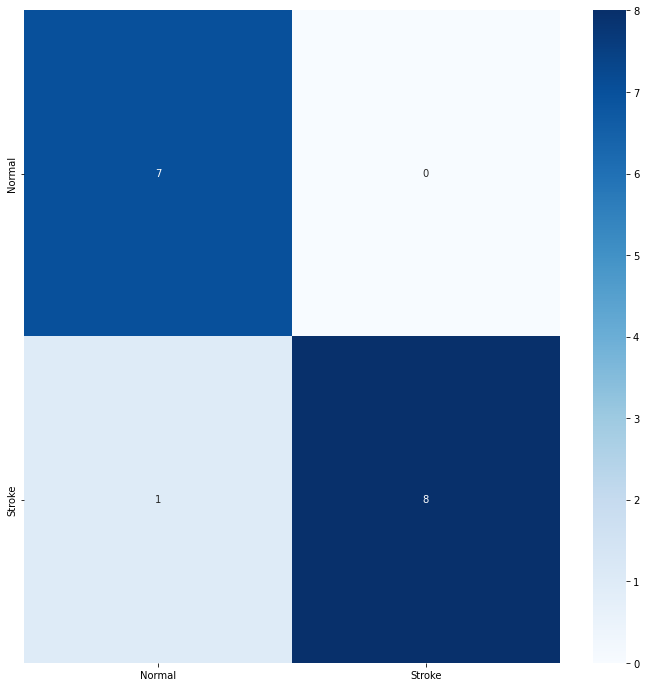

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for images, labels in test_df:
  break

Y_pred = model_vgg16.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(labels, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(labels, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

**LLE**

In [ ]:
featuresLLE = lle(model_vgg16, valid_df)
print2D(featuresLLE, "LLE projection of the dataset")
print3D(featuresLLE, "LLE projection of the dataset", valid_df)

ValueError: ignored

**Isomap**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


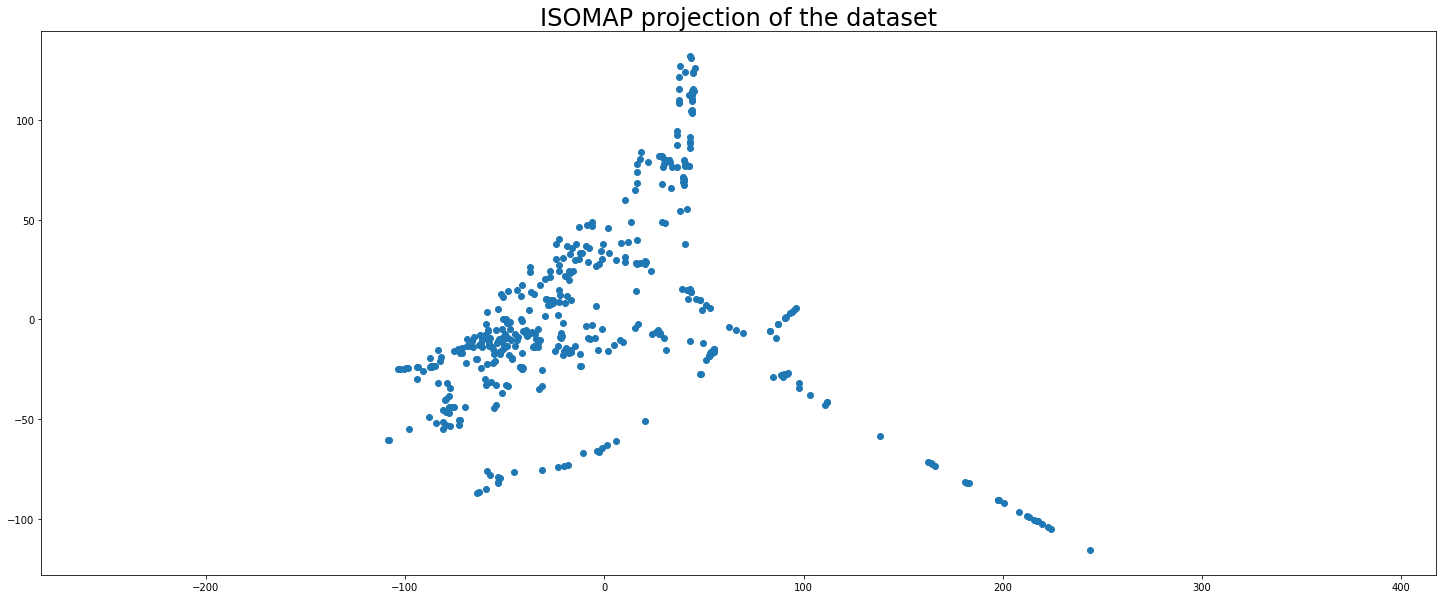

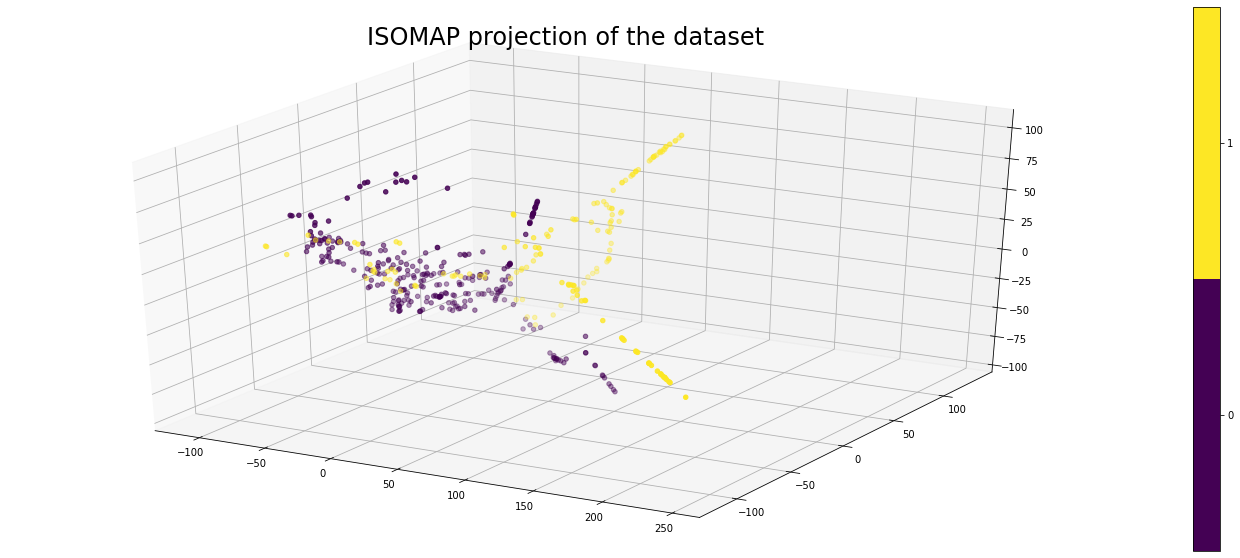

In [ ]:
featuresIsomap = isomap(eff_model, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

**t-SNE**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


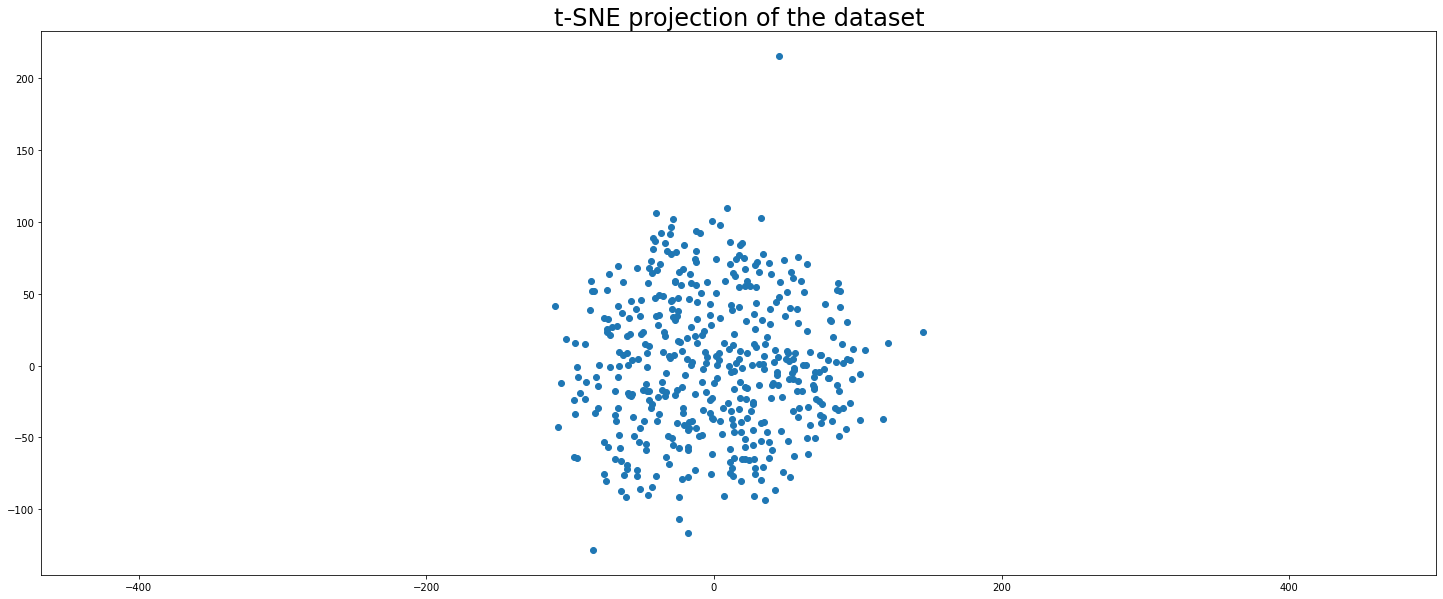

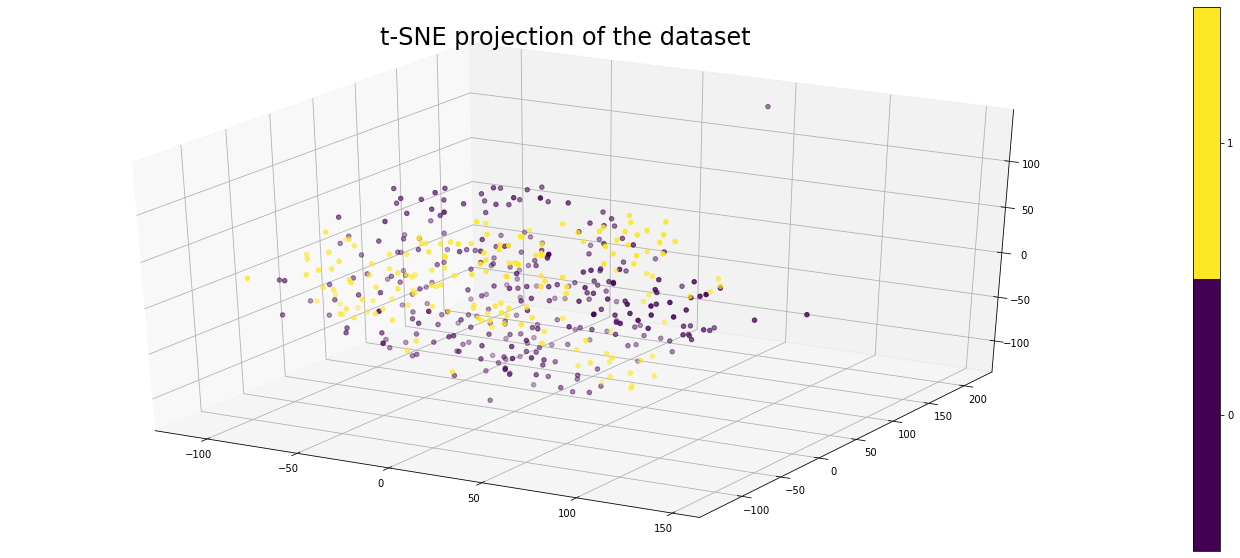

In [ ]:
featuresTSNE = tsne(eff_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

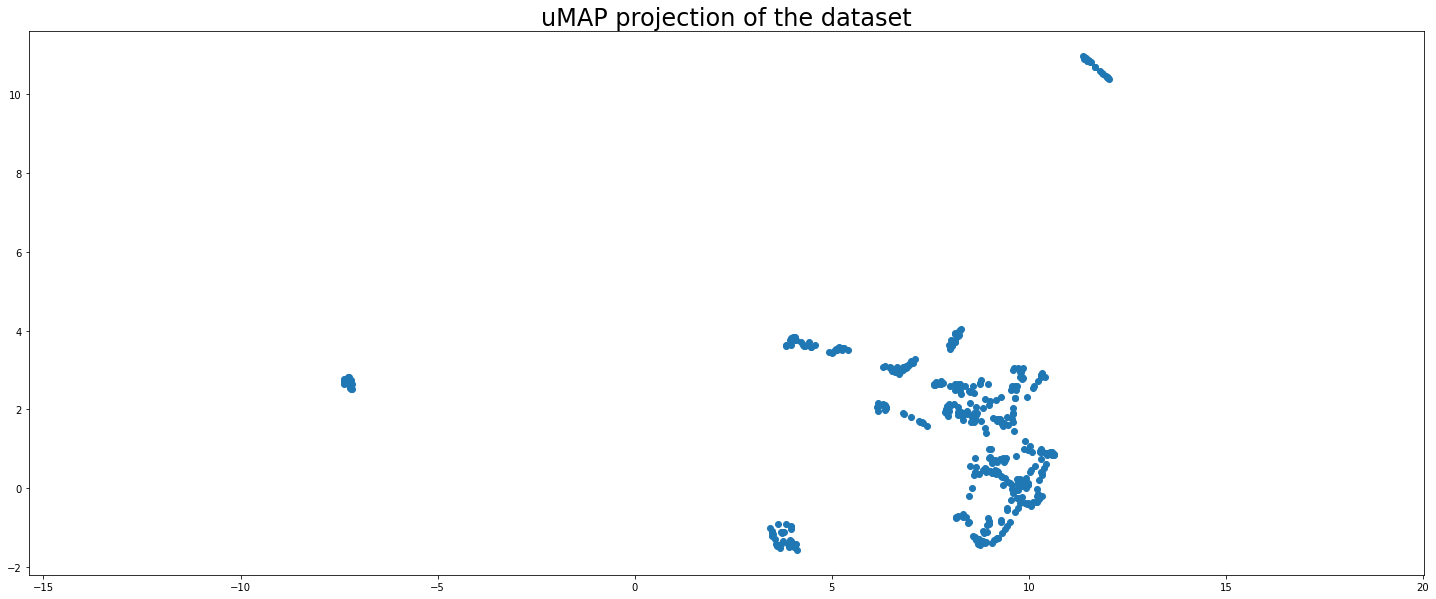

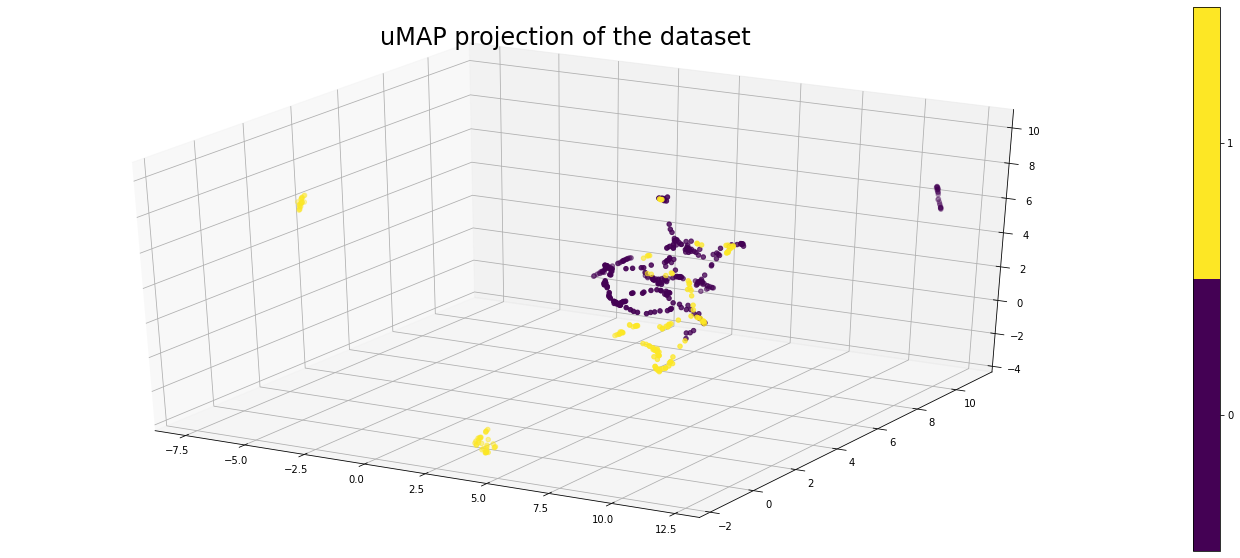

In [ ]:
featuresUMAP = uMAP(eff_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)

# DenseNet121

## Build Model

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
model_densenet = tf.keras.models.Model(name = "densenet121", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_densenet.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

In [ ]:
model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                       

## Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('dense121')
history = model_densenet.fit(train_df,
                             epochs = EPOCHS,
                             validation_data = valid_df,
                             callbacks=[callbacks])

end = datetime.now()
print(end-start)

2021-12-05 22:05:13.934257
Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.0000e+00 - tp: 621.0000 - fp: 29.0000 - tn: 1118.0000 - fn: 33.0000 - BinaryAccuracy: 0.9656 - precision: 0.9554 - recall: 0.9495 - auc: 0.9937
Epoch 00001: val_loss improved from inf to 0.16329, saving model to model.dense121.h5
113/113 [==============================] - 19s 161ms/step - loss: 0.0950 - accuracy: 0.0000e+00 - tp: 621.0000 - fp: 29.0000 - tn: 1118.0000 - fn: 33.0000 - BinaryAccuracy: 0.9656 - precision: 0.9554 - recall: 0.9495 - auc: 0.9937 - val_loss: 0.1633 - val_accuracy: 0.1511 - val_tp: 168.0000 - val_fp: 9.0000 - val_tn: 264.0000 - val_fn: 9.0000 - val_BinaryAccuracy: 0.9600 - val_precision: 0.9492 - val_recall: 0.9492 - val_auc: 0.9871 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.0022 - tp: 610.0000 - fp: 39.0000 - tn: 1108.0000 - fn: 44.0000 - BinaryAccuracy: 0.9539 - precision: 0.9399 - 

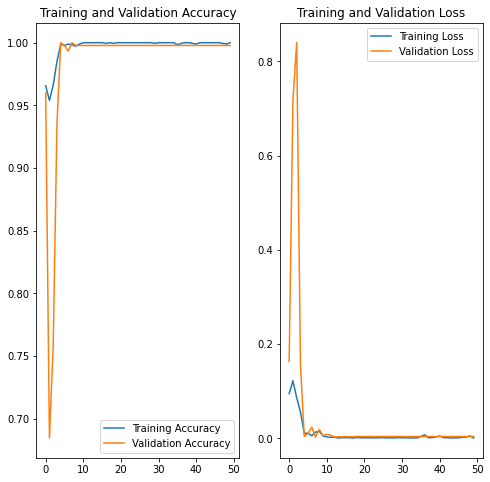

In [ ]:
print_train_results(history)

In [ ]:
!cp '/content/model.dense121.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.dense121.h5'

## Evaluate Model

In [ ]:
# get results
results = model_densenet.evaluate(test_df, steps = len(test_df), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 44ms/step - loss: 0.1900 - accuracy: 0.0000e+00 - tp: 120.0000 - fp: 6.0000 - tn: 119.0000 - fn: 5.0000 - BinaryAccuracy: 0.9560 - precision: 0.9524 - recall: 0.9600 - auc: 0.9810


In [ ]:
# show results
print('DesnseNet121:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

DesnseNet121:
---------------
ACCURACY: 0.956
Binary Accuracy: 0.9559999704360962
Precision: 0.9523809552192688
Recall: 0.9599999785423279
AUC: 0.9810240268707275
F1 Score: 0.9561752895917519


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        10
      Stroke       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix
[[10  0]
 [ 1  5]]


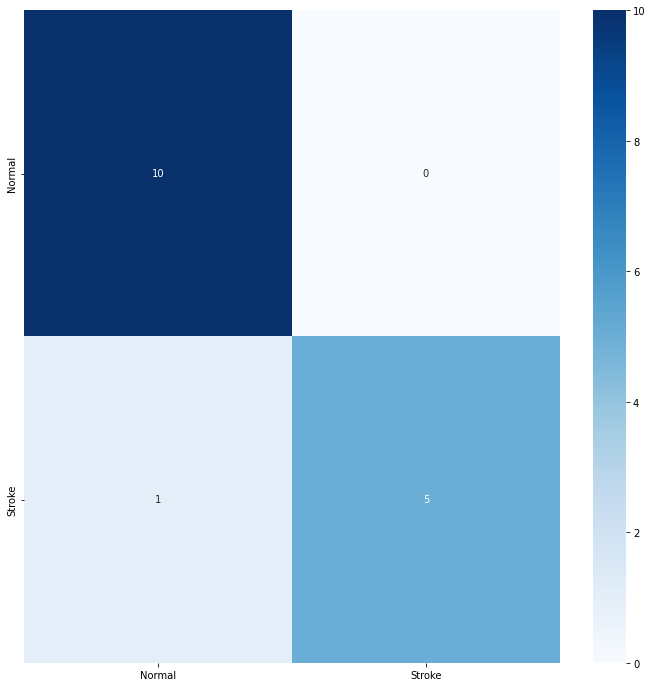

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for images, labels in test_df:
  break

Y_pred = model_densenet.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(labels, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(labels, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

**LLE**

In [ ]:
featuresLLE = lle(eff_model, valid_set)
print2D(featuresLLE, "LLE projection of the dataset")
print3D(featuresLLE, "LLE projection of the dataset", valid_set)

ValueError: ignored

**Isomap**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


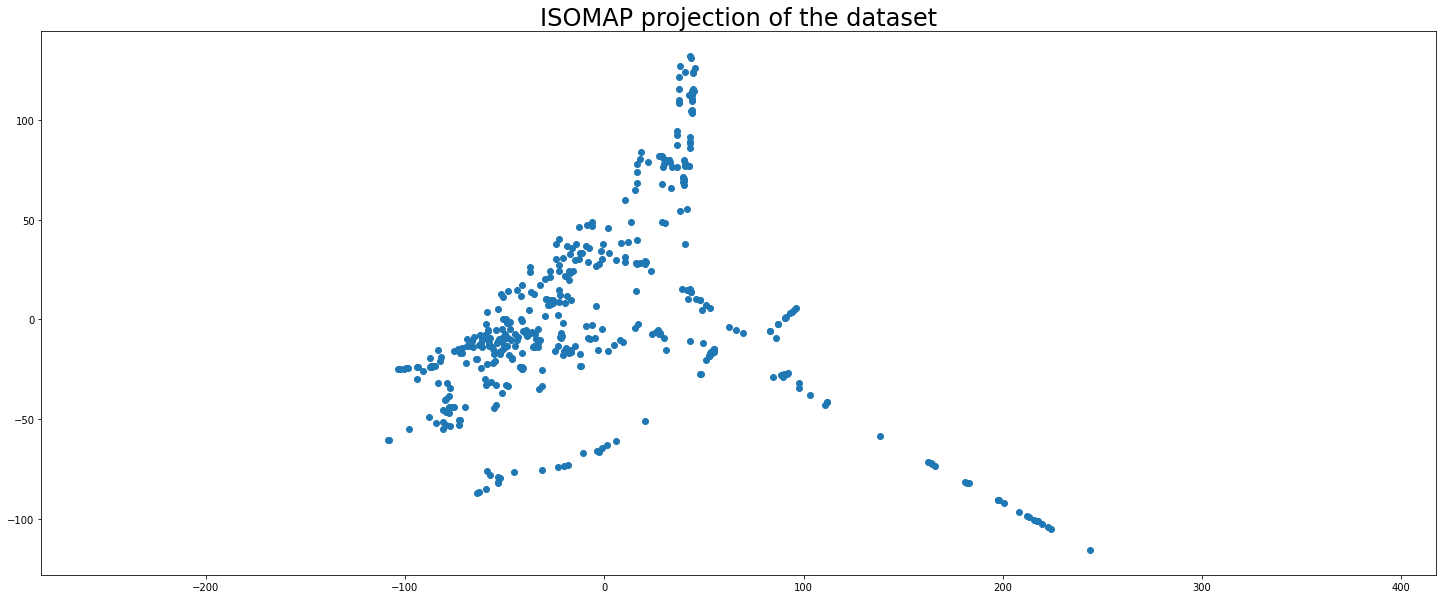

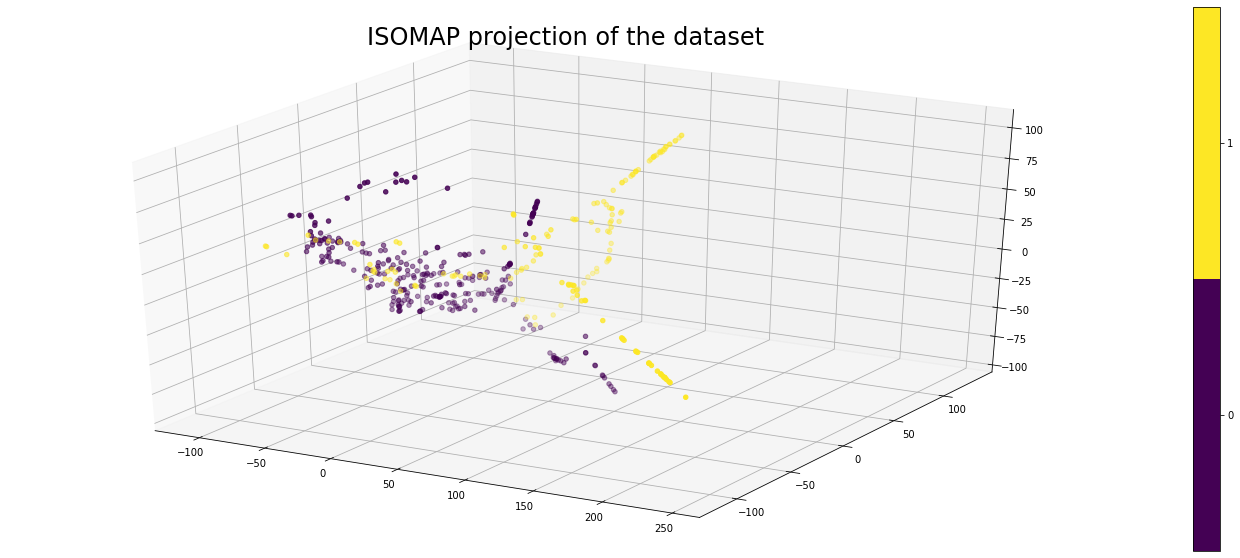

In [ ]:
featuresIsomap = isomap(eff_model, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

**t-SNE**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


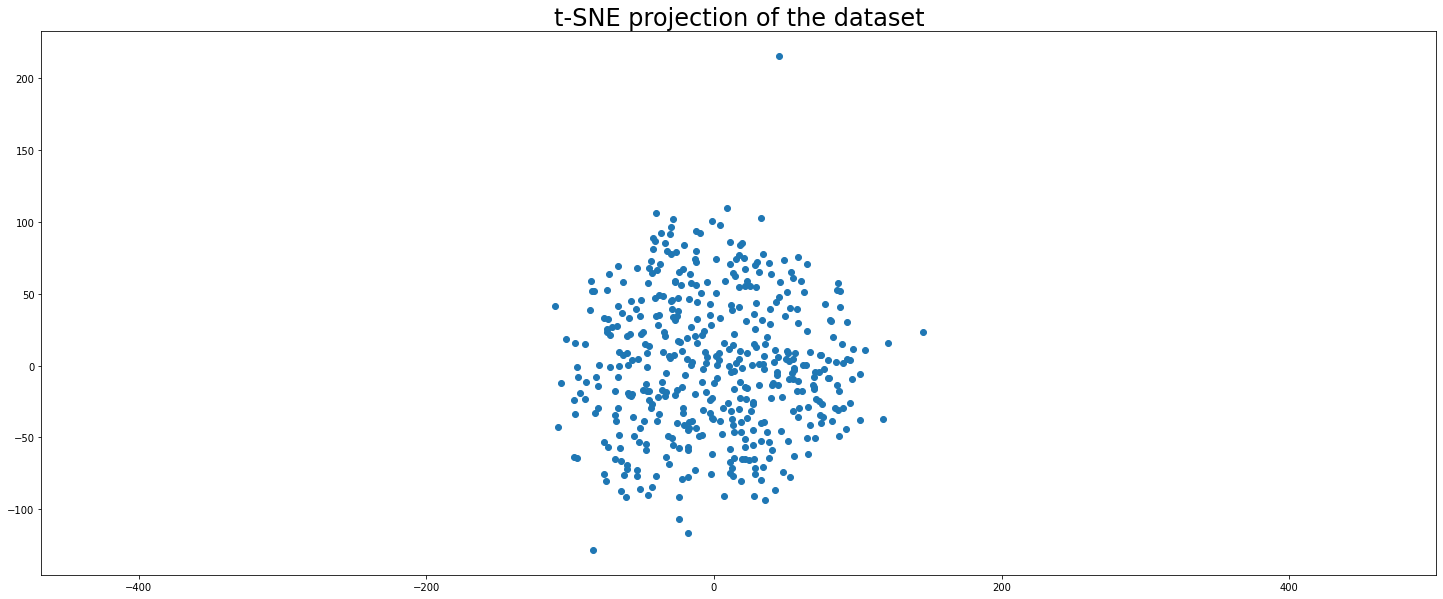

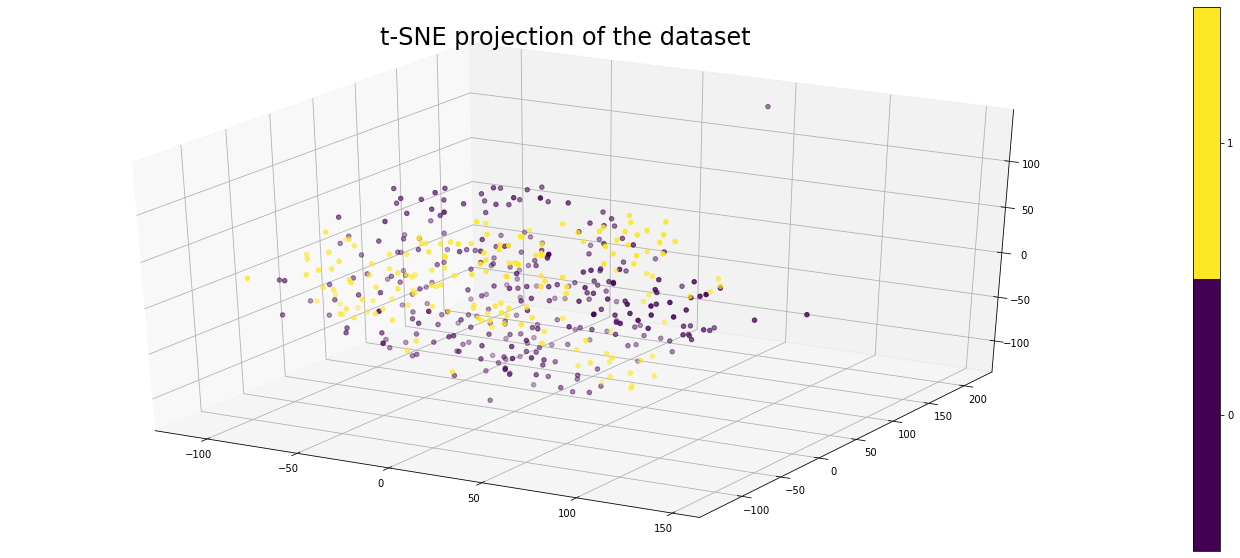

In [ ]:
featuresTSNE = tsne(eff_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

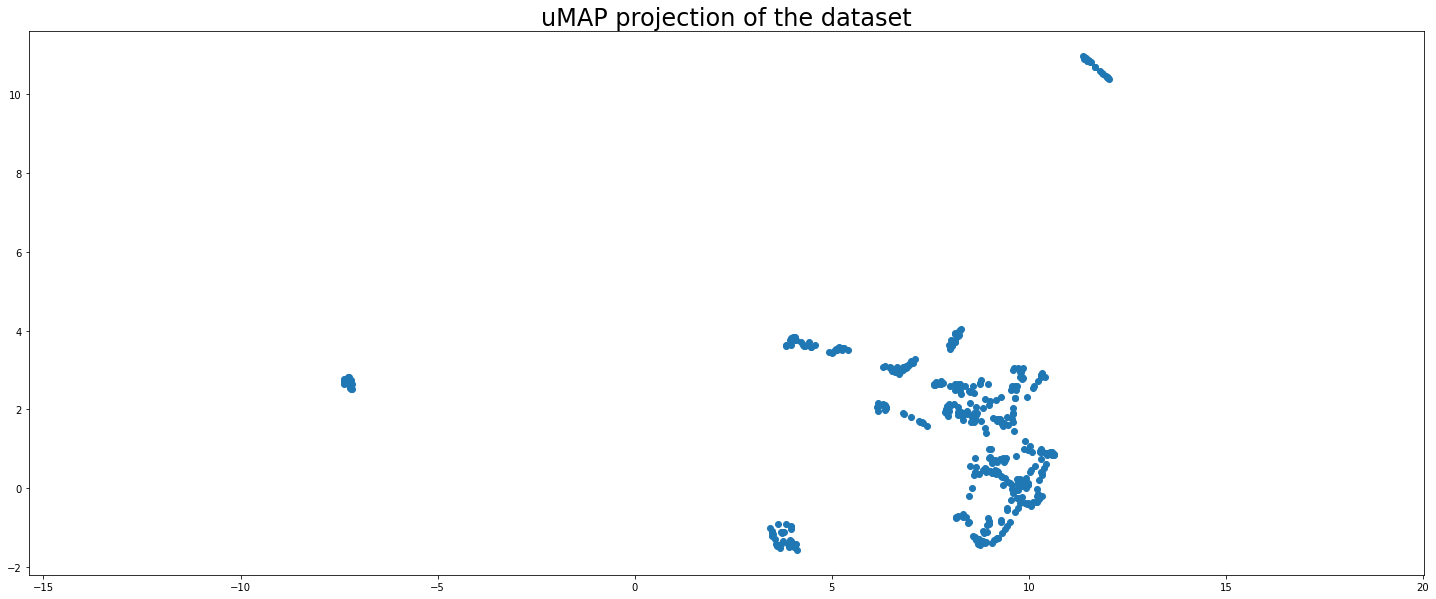

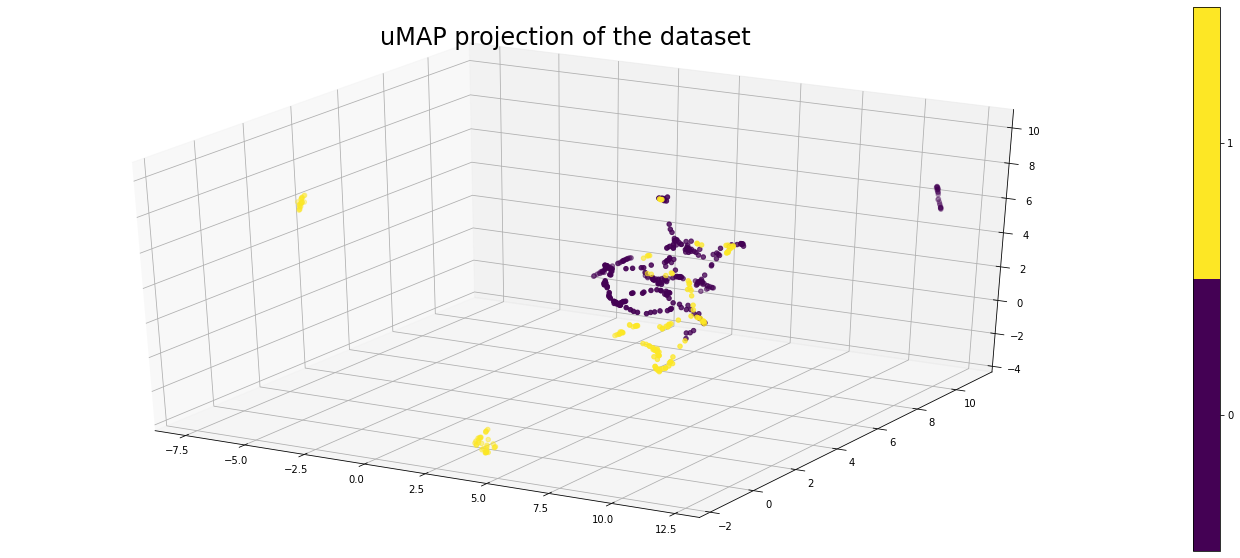

In [ ]:
featuresUMAP = uMAP(eff_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)

# EfficientNet

## Build Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
model_effnet = tf.keras.models.Model(name = "efficientnetb2", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_effnet.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
model_effnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

## Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb2')
history = model_effnet.fit(train_df,
                           epochs = EPOCHS,
                           validation_data = val_df,
                           callbacks=[callbacks])

end = datetime.now()
print(end-start)

2021-12-05 20:25:03.944201
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


113/113 [==============================] - ETA: 0s - loss: 0.6014 - tp: 450.0000 - fp: 244.0000 - tn: 1028.0000 - fn: 329.0000 - BinaryAccuracy: 0.7206 - precision: 0.6484 - recall: 0.5777 - auc: 0.7848
Epoch 00001: val_loss improved from inf to 0.51688, saving model to model.efficientnetb2.h5
113/113 [==============================] - 46s 251ms/step - loss: 0.6014 - tp: 450.0000 - fp: 244.0000 - tn: 1028.0000 - fn: 329.0000 - BinaryAccuracy: 0.7206 - precision: 0.6484 - recall: 0.5777 - auc: 0.7848 - val_loss: 0.5169 - val_tp: 135.0000 - val_fp: 73.0000 - val_tn: 200.0000 - val_fn: 42.0000 - val_BinaryAccuracy: 0.7444 - val_precision: 0.6490 - val_recall: 0.7627 - val_auc: 0.8468 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.3321 - tp: 530.0000 - fp: 121.0000 - tn: 1026.0000 - fn: 124.0000 - BinaryAccuracy: 0.8640 - precision: 0.8141 - recall: 0.8104 - auc: 0.9284
Epoch 00002: val_loss improved from 0.51688 to 0.23665, saving model to model.effic

In [ ]:
print_train_results(history)

In [ ]:
!cp '/content/model.efficientnetb2.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.efficientnetb2.h5'

## Evaluate Model

In [ ]:
# get results
results = model_effnet.evaluate(test_df, steps = len(test_df), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 40ms/step - loss: 0.1270 - tp: 118.0000 - fp: 4.0000 - tn: 121.0000 - fn: 7.0000 - BinaryAccuracy: 0.9560 - precision: 0.9672 - recall: 0.9440 - auc: 0.9926


In [ ]:
# show results
print('EfficientNetB2:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB2:
---------------
ACCURACY: 0.956
Binary Accuracy: 0.9559999704360962
Precision: 0.9672130942344666
Recall: 0.9440000057220459
AUC: 0.99263995885849
F1 Score: 0.9554655799633747


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         8
      Stroke       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Confusion Matrix
[[8 0]
 [0 8]]


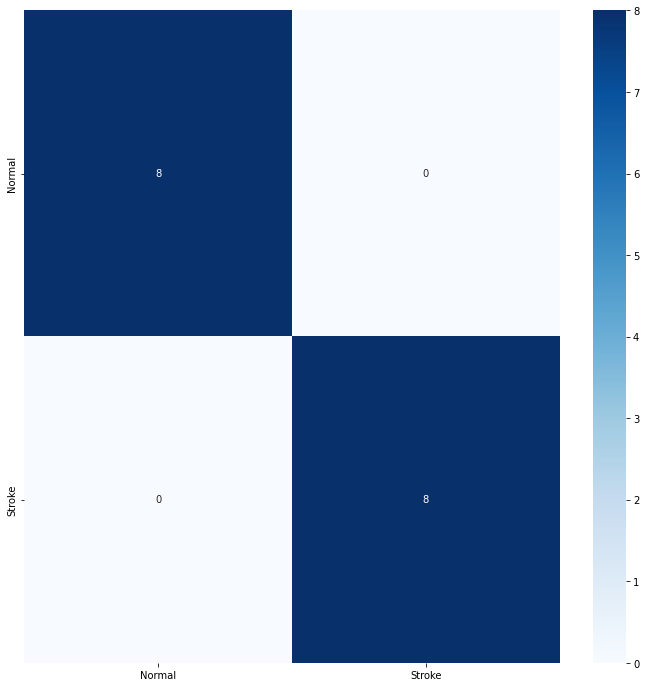

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for images, labels in test_df:
  break

Y_pred = model_effnet.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(labels, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(labels, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

**LLE**

In [ ]:
embeddingLLE = LocallyLinearEmbedding(n_components=3)
model_len = len(model_effnet.layers)
model_top_len = 4
out_model = tf.keras.models.Model(inputs  = model_effnet.input,
                                  outputs = model_effnet.layers[model_len - model_top_len].output)
Y_pred = out_model.predict(val_df)

featuresLLE = embeddingLLE.fit_transform(Y_pred)

ValueError: ignored

In [ ]:
featuresLLE = lle(model_effnet, val_df)
print2D(featuresLLE, "LLE projection of the dataset")
print3D(featuresLLE, "LLE projection of the dataset", val_df)

ValueError: ignored

**Isomap**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


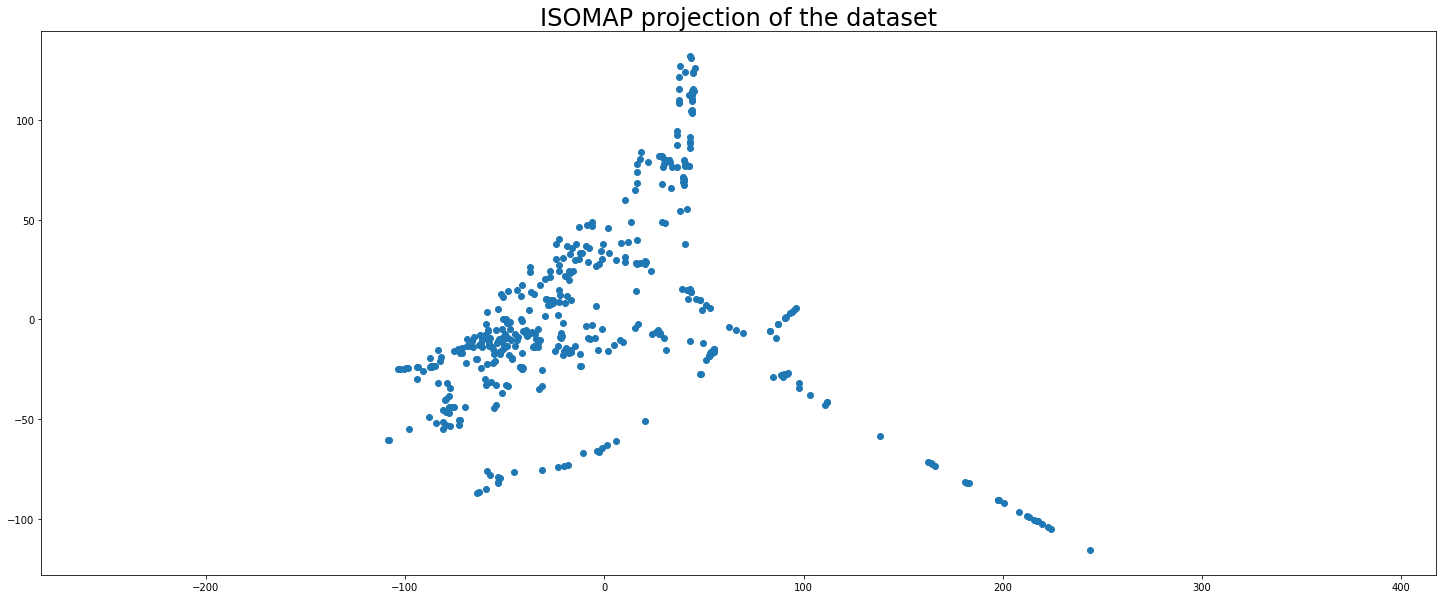

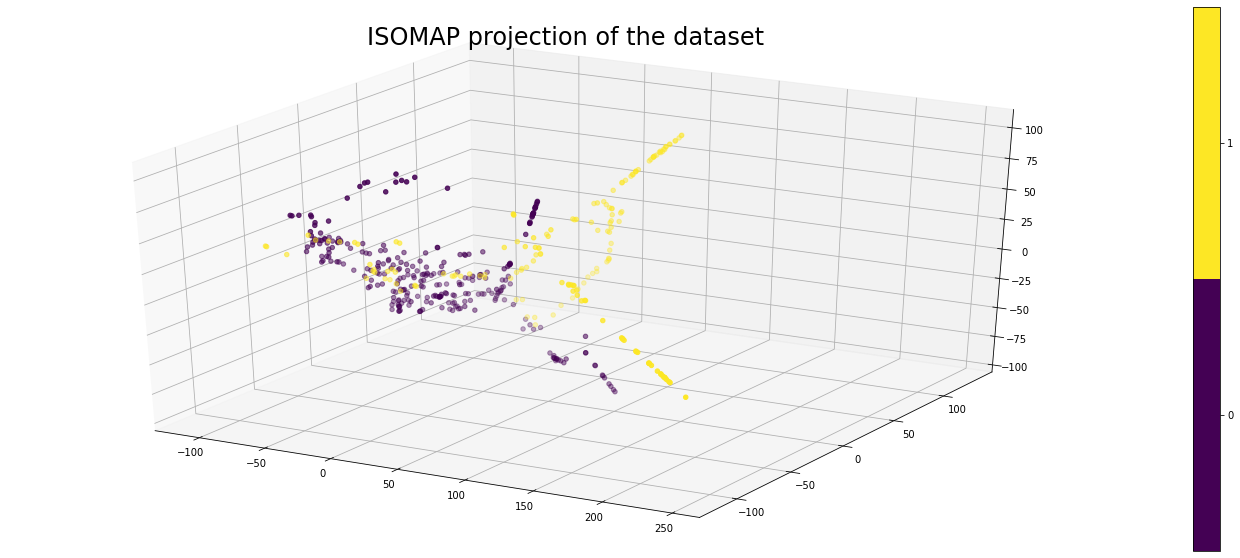

In [ ]:
featuresIsomap = isomap(eff_model, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

**t-SNE**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


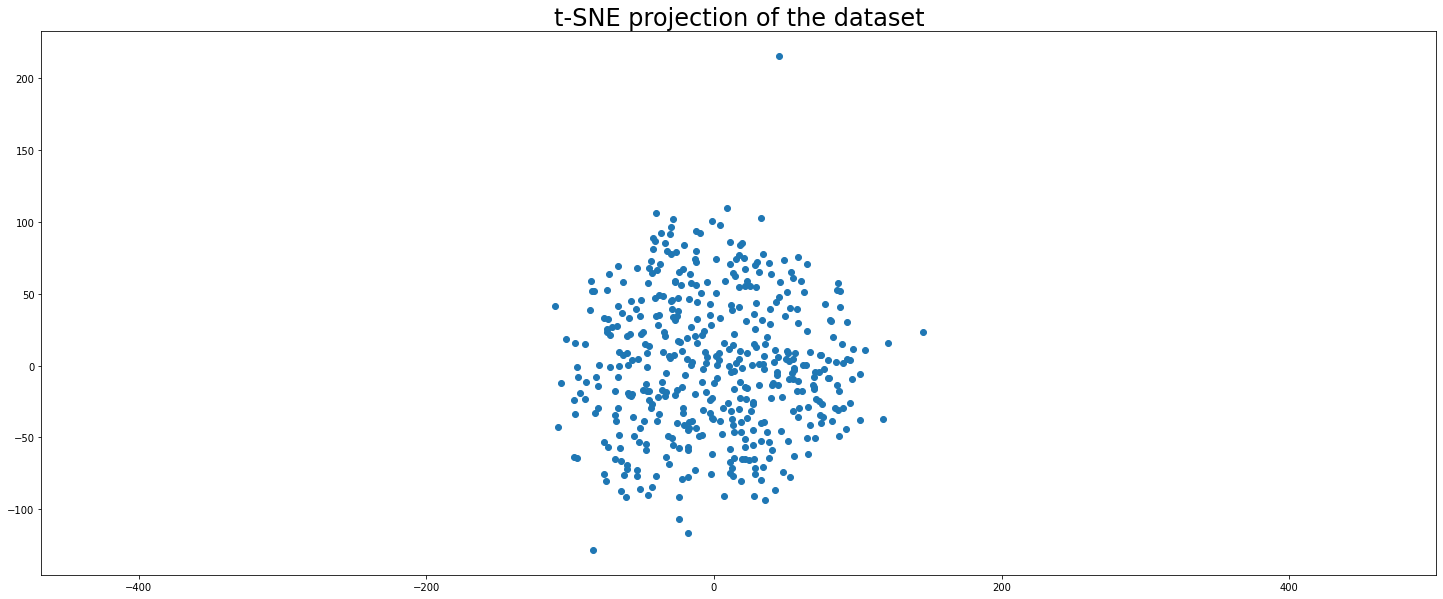

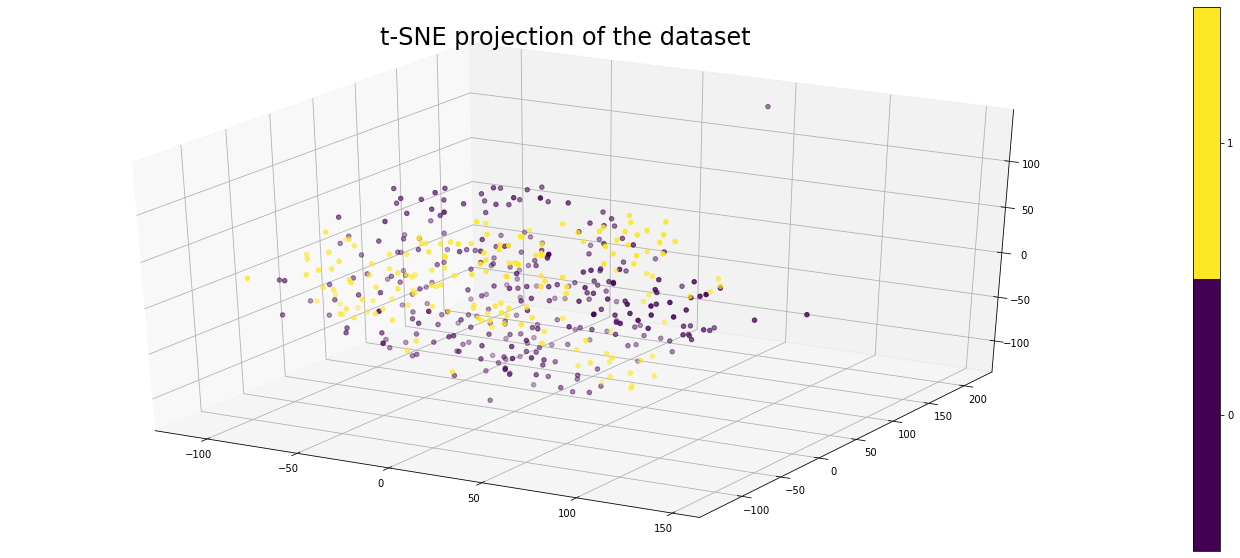

In [ ]:
featuresTSNE = tsne(eff_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

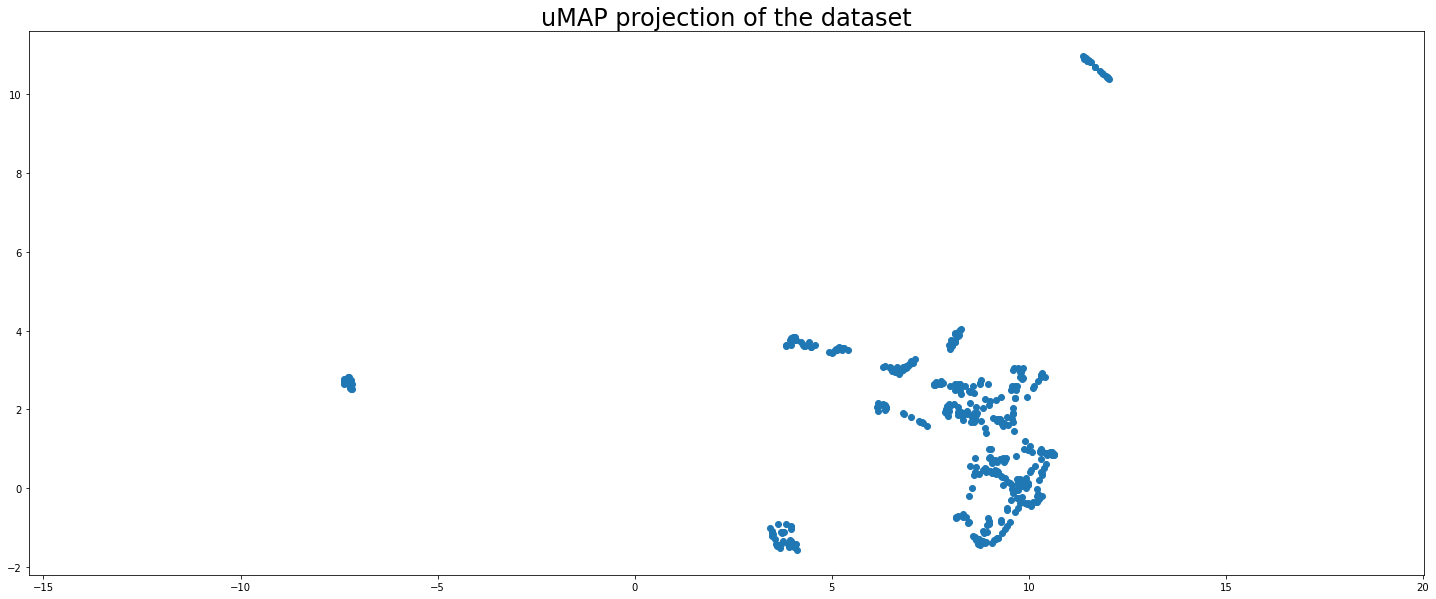

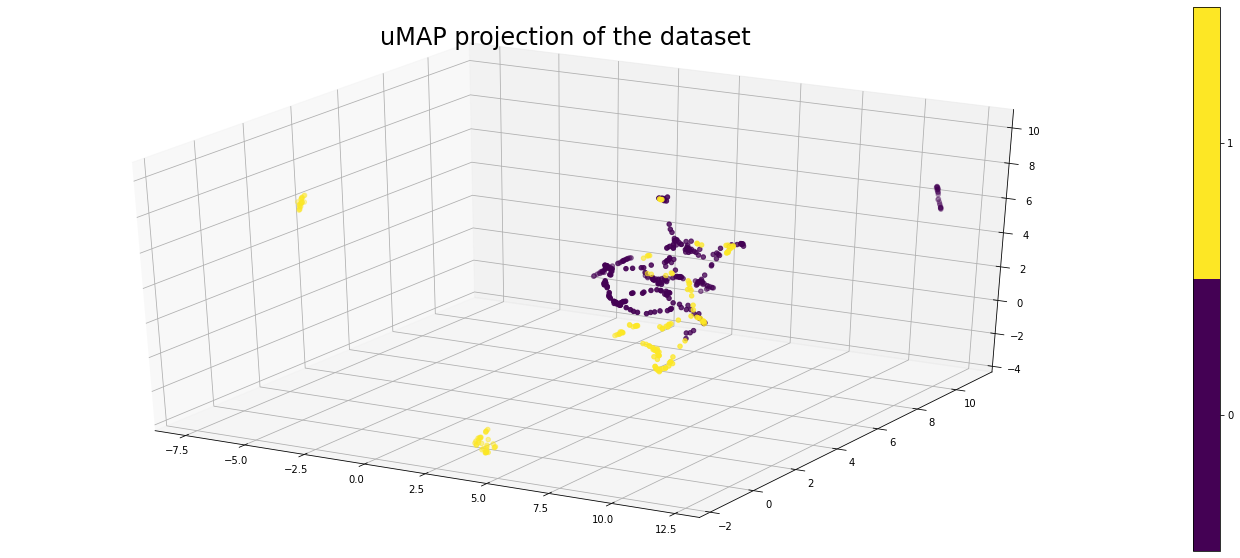

In [ ]:
featuresUMAP = uMAP(eff_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)

# ViT B16

## Build Model

In [ ]:
!pip install -U vit-keras
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [ ]:
# build vit model with 16 patch_size
from vit_keras import vit

base_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

vit_features = base_model.output

x = base_model.output
x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
vit_model = tf.keras.models.Model(name = "vit_b16", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
vit_model.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


In [ ]:
vit_model.summary()

Model: "vit_b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb16')
history = vit_model.fit(train_df,
                        epochs = EPOCHS,
                        validation_data = valid_df,
                        callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-05 22:55:43.581372
Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.0000e+00 - tp: 449.0000 - fp: 265.0000 - tn: 882.0000 - fn: 205.0000 - BinaryAccuracy: 0.7390 - precision: 0.6289 - recall: 0.6865 - auc: 0.7995
Epoch 00001: val_loss improved from inf to 0.93402, saving model to model.vitb16.h5
113/113 [==============================] - 78s 512ms/step - loss: 0.6256 - accuracy: 0.0000e+00 - tp: 449.0000 - fp: 265.0000 - tn: 882.0000 - fn: 205.0000 - BinaryAccuracy: 0.7390 - precision: 0.6289 - recall: 0.6865 - auc: 0.7995 - val_loss: 0.9340 - val_accuracy: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 273.0000 - val_fn: 177.0000 - val_BinaryAccuracy: 0.6067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9257 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.0000e+00 - tp: 466.0000 - fp: 155.0000 - tn: 992.0000 - fn: 188.0000 - BinaryAccuracy: 0.80

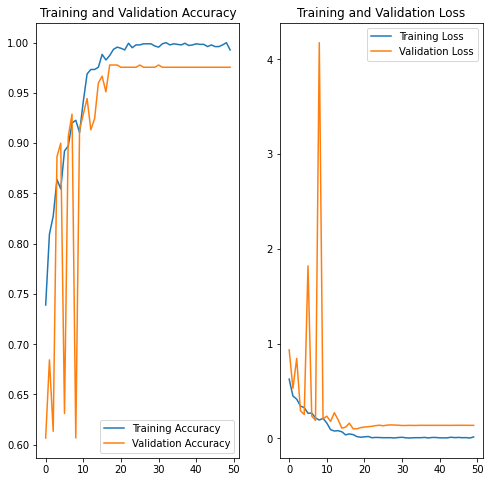

In [ ]:
print_train_results(history)

In [ ]:
!cp '/content/model.vitb16.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vitb16.h5'

## Evaluate Model

In [ ]:
# get results
results = vit_model.evaluate(test_df, steps = len(test_df), verbose = 1, return_dict = True)

16/16 [==============================] - 3s 157ms/step - loss: 0.4629 - accuracy: 0.0560 - tp: 113.0000 - fp: 8.0000 - tn: 117.0000 - fn: 12.0000 - BinaryAccuracy: 0.9200 - precision: 0.9339 - recall: 0.9040 - auc: 0.9521


In [ ]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.92
Binary Accuracy: 0.9200000166893005
Precision: 0.93388432264328
Recall: 0.9039999842643738
AUC: 0.952064037322998
F1 Score: 0.9186991910222451


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         8
      Stroke       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Confusion Matrix
[[8 0]
 [0 8]]


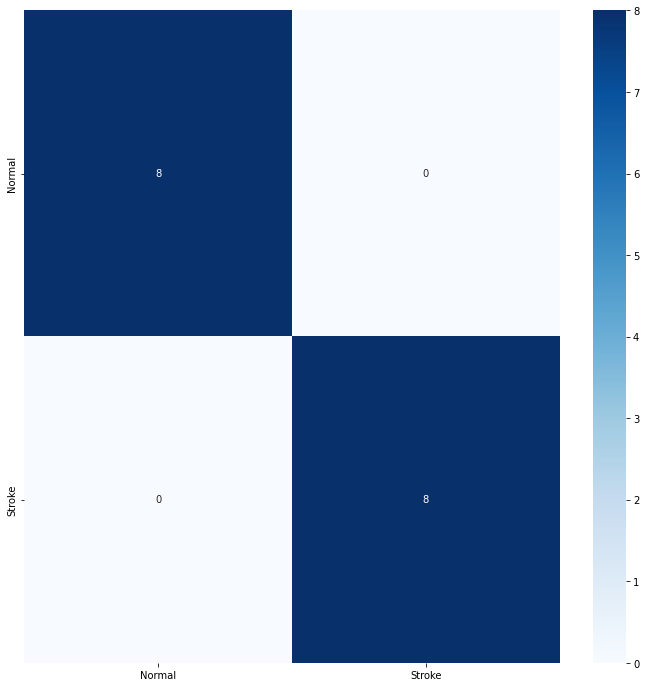

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for images, labels in test_df:
  break

Y_pred = vit_model.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(labels, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(labels, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

**LLE**

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

def lle(model, dataset, feature=True):
  embeddingLLE = LocallyLinearEmbedding(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresLLE = embeddingLLE.fit_transform(Y_pred)
  return featuresLLE

In [ ]:
# featuresLLE = lle(vit_model, valid_df)
from sklearn.manifold import LocallyLinearEmbedding
import numpy as np

for image_batch, labels_batch in valid_df:
  break

val_df_images = np.concatenate([x for x, y in valid_df], axis=0)
val_df_labels = np.concatenate([y for x, y in valid_df], axis=0)

model_len = len(vit_model.layers)
model_top_len = 4
out_model = tf.keras.models.Model(inputs  = vit_model.input,
                                  outputs = vit_model.layers[model_len - model_top_len].output)
Y_pred = out_model.predict(val_df_images)
print(Y_pred.shape)

feature_list = []
for y_pred in Y_pred:
  feature_np = np.array(y_pred)
  feature_list.append(feature_np.flatten())

feature_list_np = np.array(feature_list)

embeddingLLE = LocallyLinearEmbedding(n_components=3)
featuresLLE = embeddingLLE.fit_transform(feature_list_np)

(450, 197, 768)


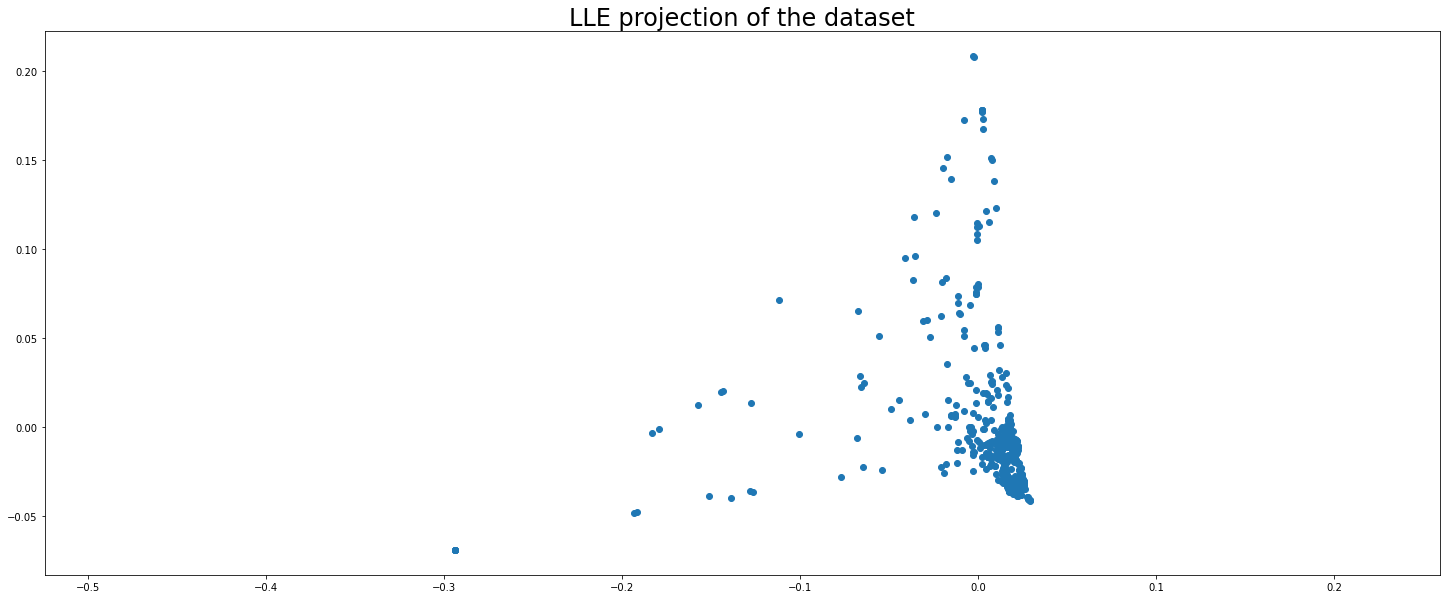

In [ ]:
print2D(featuresLLE, "LLE projection of the dataset")

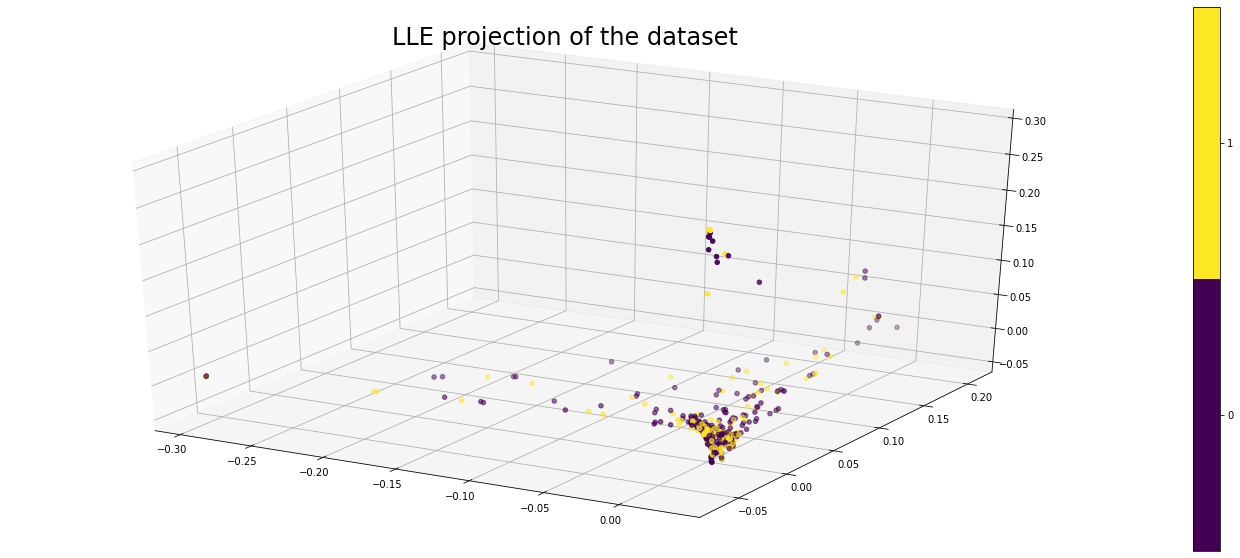

In [ ]:
print3D(featuresLLE, "LLE projection of the dataset", val_df_labels)

**Isomap**

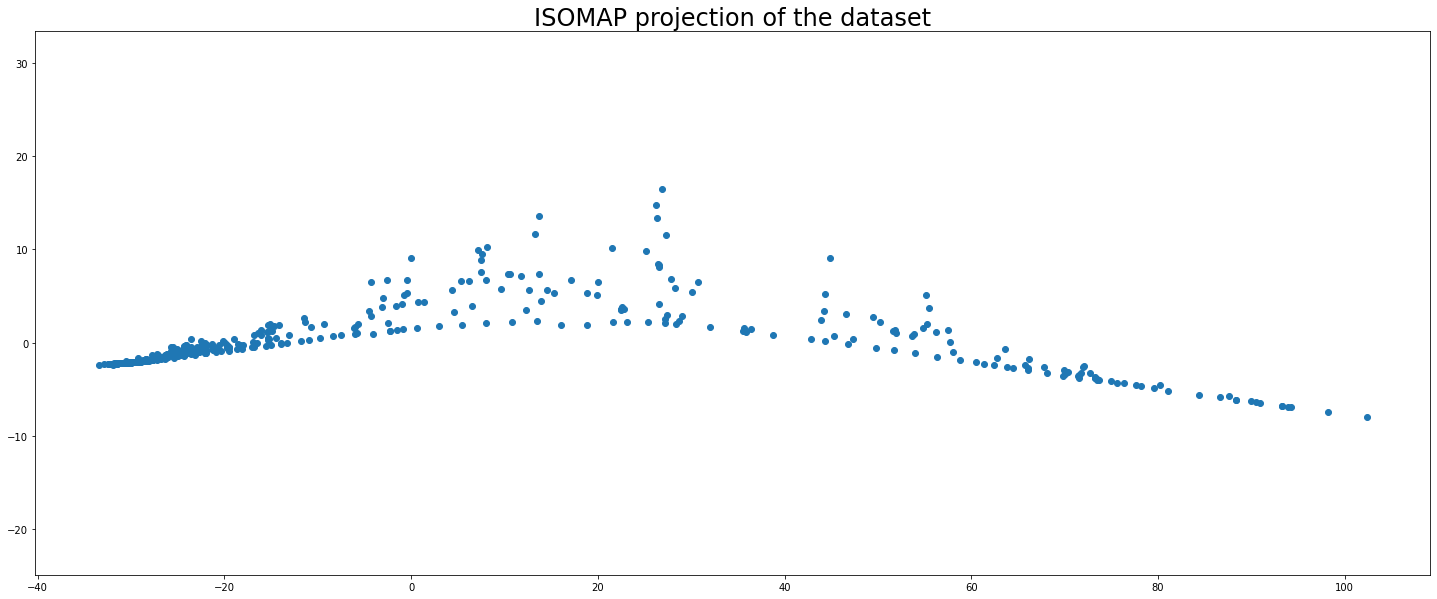

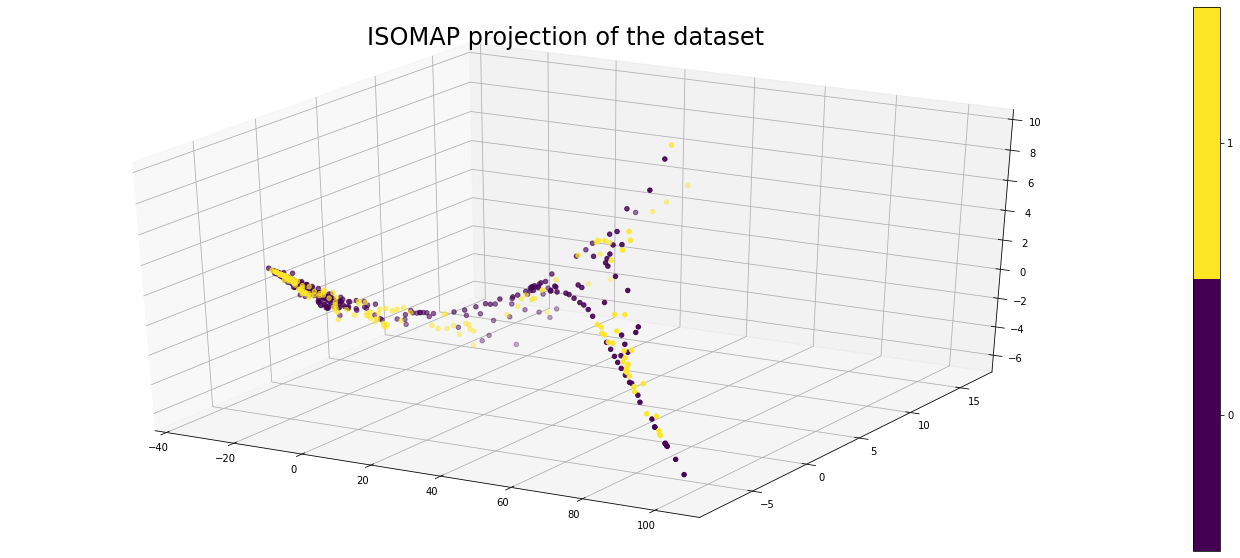

In [ ]:
featuresIsomap = isomap(vit_model, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

**t-SNE**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


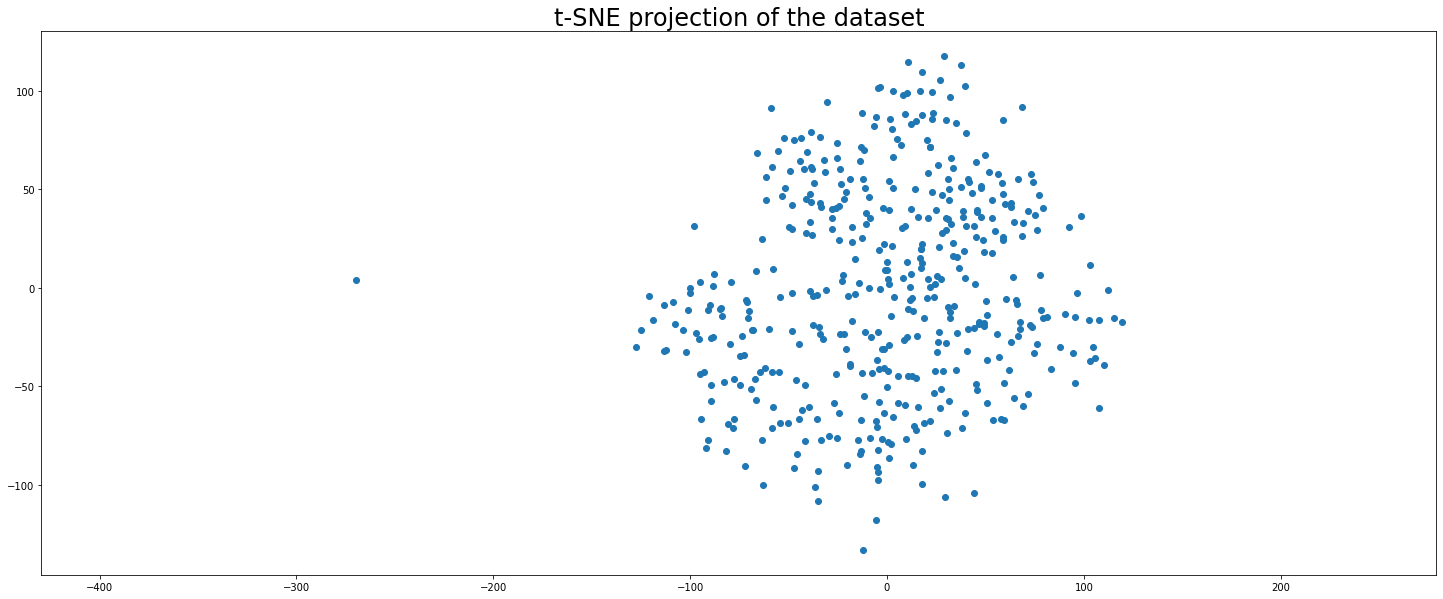

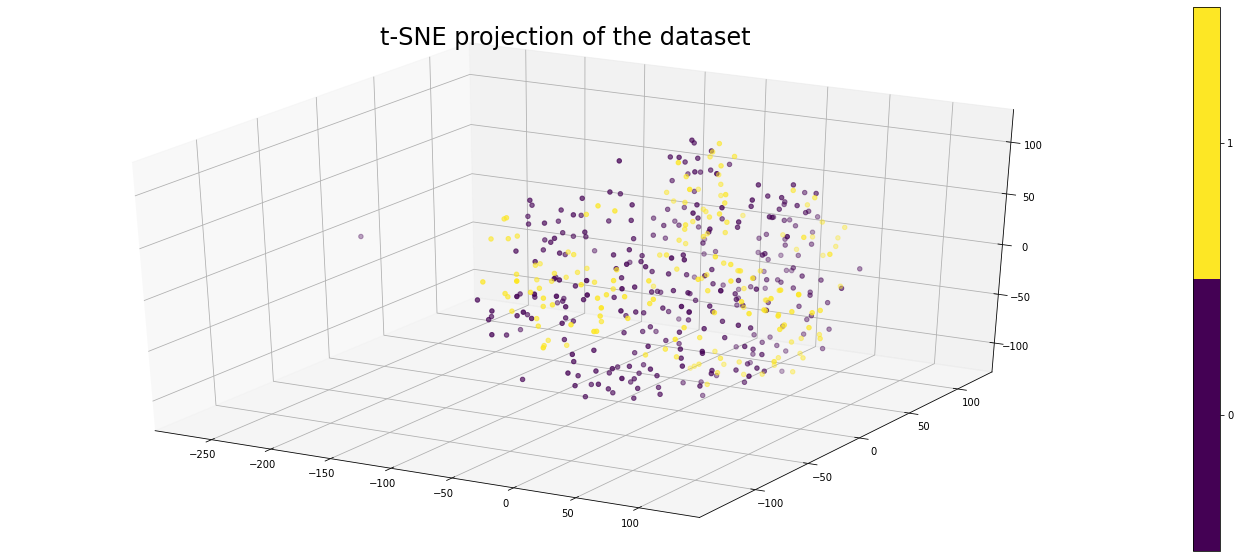

In [ ]:
featuresTSNE = tsne(vit_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

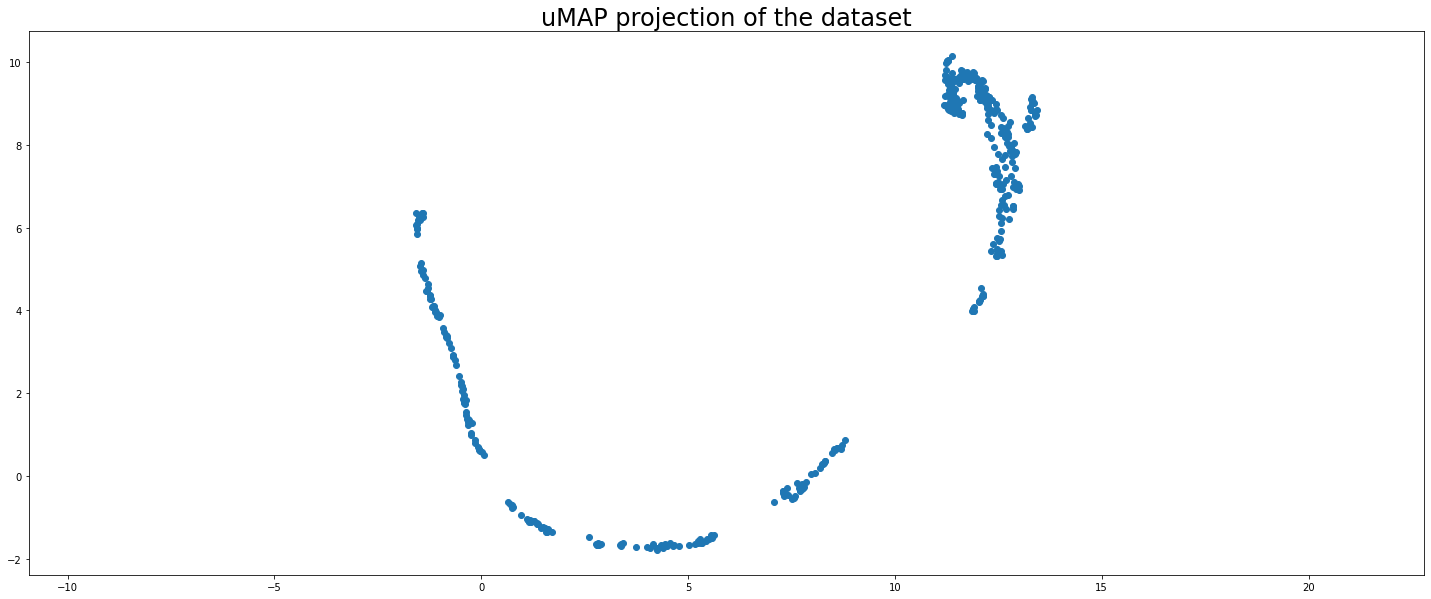

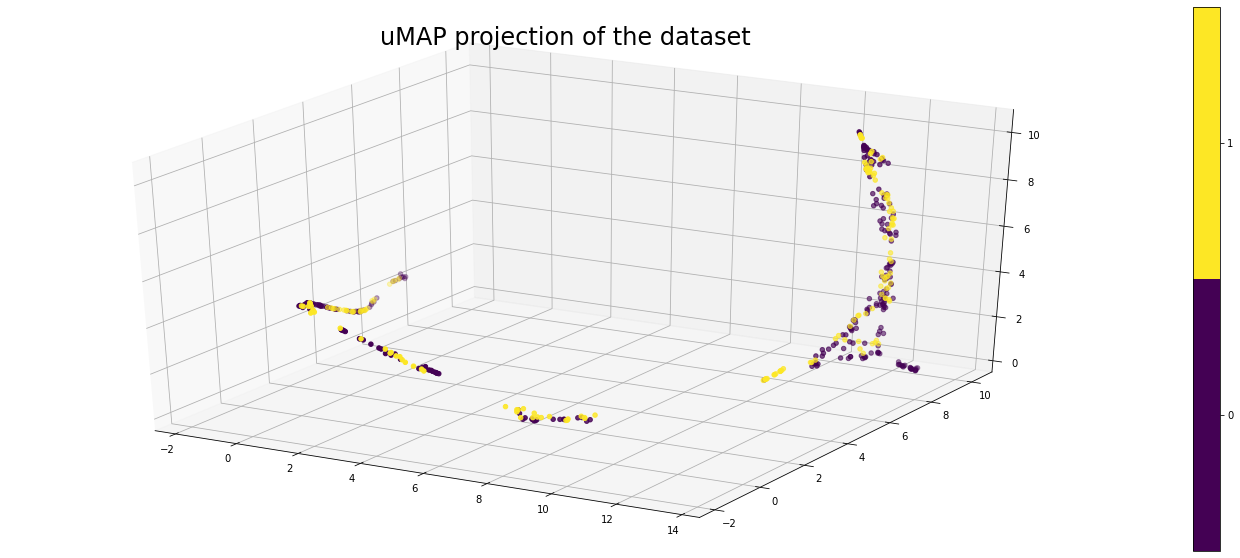

In [ ]:
featuresUMAP = uMAP(vit_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)